<a href="https://colab.research.google.com/github/w1767/MSc-project/blob/main/Stock_Volatility_GARCH_MC_LSTM_SVM_RF_30_Oct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Volatility Prediction Using GARCH, Monte Carlo, LSTM, SVM and Random Forest

In [1]:
!pip install arch
!pip install tensor
!pip install tensorflow
!pip install statsmodels
!pip install keras
!pip install sklearn
import tensorflow
import keras
import sklearn
from pathlib import Path
from datetime import datetime, timedelta
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
from arch import arch_model
from sklearn.svm import SVR
from sklearn import metrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import os
import glob
import csv
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.ensemble import RandomForestRegressor
from keras.models import load_model
from sklearn import metrics

     |████████████████████████████████| 899 kB 29.5 MB/s 
     |████████████████████████████████| 9.8 MB 49.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 50 kB 8.0 MB/s 
     |████████████████████████████████| 3.1 MB 37.3 MB/s 
     |████████████████████████████████| 57 kB 5.2 MB/s 
     |████████████████████████████████| 296 kB 73.4 MB/s 
     |████████████████████████████████| 1.9 MB 80.1 MB/s 
     |████████████████████████████████| 80 kB 12.5 MB/s 
     |████████████████████████████████| 49 kB 9.0 MB/s 
     |████████████████████████████████| 74 kB 4.9 MB/s 
     |████████████████████████████████| 251 kB 75.1 MB/s 
  Created wheel for tensor: filename=tensor-0.3.6-py3-none-any.whl size=71568 sha256=718d9c5006aa05c8be5cb251896dd1e4e6ceb3c4ee71270943e88e23b6f1512b
  Stored in directory: /root/.cache/pip/wheels

### Reading the dataset from your local directory

In [2]:
#os.chdir('D:\GU_Project') 

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path = "/content/drive/MyDrive/Master thesis/VIX.csv"

In [8]:
VI_db=pd.read_csv("/content/drive/MyDrive/Master thesis/VIX.csv")

In [9]:
VI_db.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,02/01/1990,17.240000,17.240000,17.240000,17.240000,17.240000,0
1,03/01/1990,18.190001,18.190001,18.190001,18.190001,18.190001,0
2,04/01/1990,19.219999,19.219999,19.219999,19.219999,19.219999,0
3,05/01/1990,20.110001,20.110001,20.110001,20.110001,20.110001,0
4,08/01/1990,20.260000,20.260000,20.260000,20.260000,20.260000,0


### Data type formating of the required features 

In [10]:
VI_db['Date']= pd.to_datetime(VI_db['Date'])

### Features preparations

In [11]:
VI_db['log_price'] = np.log(VI_db['Close'])

In [12]:
VI_db['pct_change'] = VI_db['log_price'].diff()

In [13]:
VI_db['stdev'] = VI_db['pct_change'].rolling(window=30, center=False).std()

In [14]:
VI_db['Volatility'] = VI_db['stdev']*(252**0.5)

### Display top 100 records

In [15]:
VI_db.head(100)

,Date,Open,High,Low,Close,Adj Close,Volume,log_price,pct_change,stdev,Volatility
0,1990-02-01,17.240000,17.240000,17.240000,17.240000,17.240000,0,2.847232,NaN,NaN,NaN
1,1990-03-01,18.190001,18.190001,18.190001,18.190001,18.190001,0,2.900872,0.053640,NaN,NaN
2,1990-04-01,19.219999,19.219999,19.219999,19.219999,19.219999,0,2.955951,0.055079,NaN,NaN
3,1990-05-01,20.110001,20.110001,20.110001,20.110001,20.110001,0,3.001217,0.045266,NaN,NaN
4,1990-08-01,20.260000,20.260000,20.260000,20.260000,20.260000,0,3.008648,0.007431,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,1990-05-17,17.270000,17.270000,17.270000,17.270000,17.270000,0,2.848971,-0.025159,0.069642,1.105535
96,1990-05-18,17.200001,17.200001,17.200001,17.200001,17.200001,0,2.844909,-0.004061,0.069416,1.101950
97,1990-05-21,16.719999,16.719999,16.719999,16.719999,16.719999,0,2.816606,-0.028304,0.069241,1.099169
98,1990-05-22,17.840000,17.840000,17.840000,17.840000,17.840000,0,2.881443,0.064838,0.070293,1.115870


### Set 'Date' as index

In [17]:
to_plt = VI_db.sort_values(by = 'Date').set_index('Date')

### Plot Volatility feature from the DataFrame

Text(0.5, 1.0, 'VIX Rolling Volatility considering 30 Time Periods with Standard Deviation Annualized')

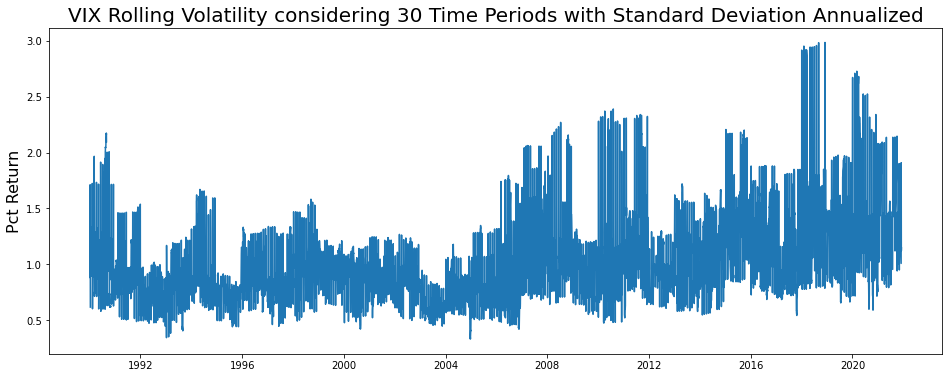

In [62]:
plt.figure(figsize=(16,6))
plt.plot(to_plt['Volatility'])
plt.ylabel('Pct Return', fontsize=16)
plt.title('VIX Rolling Volatility considering 30 Time Periods with Standard Deviation Annualized', fontsize=20)

In [19]:
df=to_plt.dropna()

In [20]:
vol = df['Volatility'] * 100

### To Check if there is null value in any of the column

In [63]:
df.isnull().any() 

Open            False
High            False
Low             False
Close           False
Adj Close       False
Volume          False
log_price       False
pct_change      False
stdev           False
Volatility      False
forecast_vol    False
dtype: bool

### Performing the ADF test to identify if the return series is stationary or non-stationary

In [64]:
result = adfuller(df.Volatility)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.631603
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


## Volatility Prediction using GARCH(3,1)

In [65]:
GARCH_Mod = arch_model(vol, vol='Garch', p=3, o=0, q=1, dist='Normal')

### GARCH Summary

In [66]:
res = GARCH_Mod.fit(disp='off')
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             Volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -38027.9
Distribution:                  Normal   AIC:                           76067.8
Method:            Maximum Likelihood   BIC:                           76109.7
                                        No. Observations:                 7904
Date:                Sat, Oct 30 2021   Df Residuals:                     7903
Time:                        12:29:59   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            88.8885      0.975     91.129      0.000 [ 86.977, 90.800]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega        110.8320     42.483      2.609  9.084e-03 [ 27.567,1.941e+02]
alpha[1]       0.4793  5.057e-02      9.476  2.638e-21   [  0.380,  0.578]
alpha[2]   1.0561e-09      0.101  1.049e-08      1.000   [ -0.197,  0.197]
alpha[3]   2.7648e-10  8.964e-02  3.084e-09      1.000   [ -0.176,  0.176]
beta[1]        0.5048      0.175      2.890  3.856e-03   [  0.162,  0.847]
==========================================================================

Covariance estimator: robust
"""

### Creating Forecasted Volatility feature

In [67]:
df['forecast_vol'] = 0.1 * np.sqrt(res.params['omega'] + res.params['alpha[1]'] * res.resid**2 + res.conditional_volatility**2 * res.params['beta[1]'])

### Ploting Actual Volatility Vs Forecasted Volatility

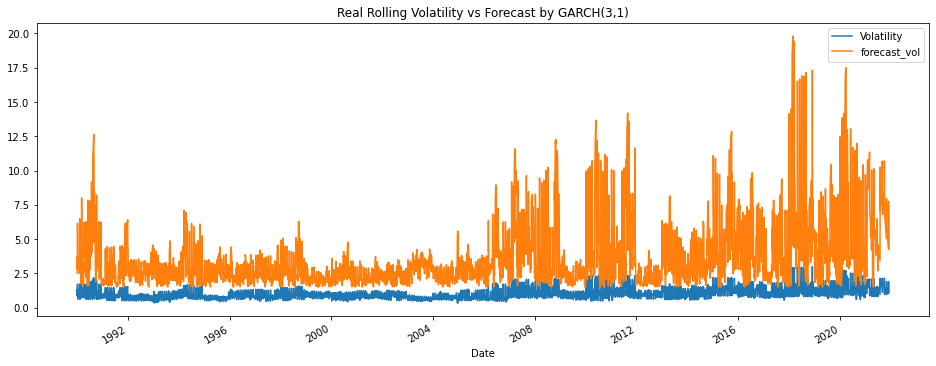

In [68]:
plt.figure(figsize=(16,6))
df["Volatility"].plot()
df["forecast_vol"].plot()
plt.title("Real Rolling Volatility vs Forecast by GARCH(3,1)")
plt.legend()
plt.show()

### Calculating RMSE value for GARCH Model

In [29]:
print('RMSE calculated for GARCH(3,1) model:', np.sqrt(metrics.mean_squared_error(df.loc[df.index[1000:], 'Volatility'], df.loc[df.index[1000:], 'forecast_vol'])))

RMSE calculated for GARCH(3,1) model: 3.235846319536613


## Volatility Prediction using LSTM

In [30]:
training_set = df.iloc[:, 9:10].values
X_train = []
y_train = []
for i in range(1000, df.shape[0]):
    X_train.append(training_set[i-1000:i,0])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Preparing X_train for RNN using LSTM

In [31]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### Ceating RNN with LSTM

In [32]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10))
regressor.add(Dropout(0.1))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 1, batch_size = 32)

216/216 [==============================] - 250s 1s/step - loss: 0.2118


### Store the result of LSTM

In [35]:
regressor.save('Volatility_VI.h5')

In [36]:
regressor = load_model('Volatility_VI.h5')

### Creating Predicted Volatility feature

In [37]:
predicted_vol = regressor.predict(X_train)

### Ploting Volatility Real Rolling  vs LSTM Forecasted

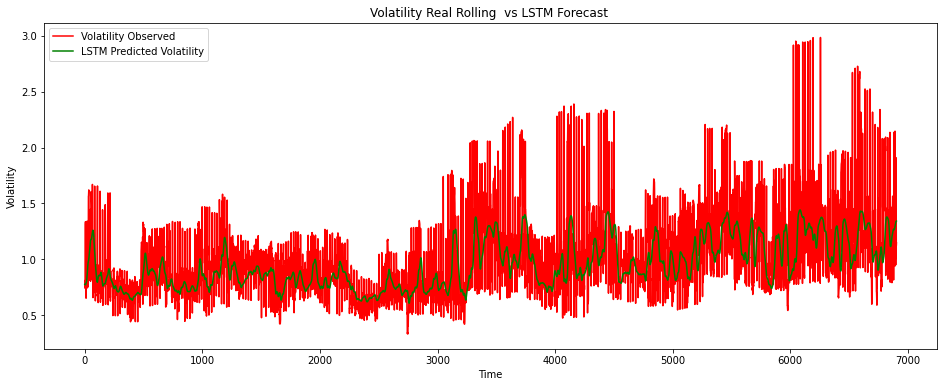

In [38]:
# Visualising the results
plt.figure(figsize=(16,6))
plt.plot(df.iloc[1000:, 9:10].values, color = 'red', label = 'Volatility Observed')
plt.plot(predicted_vol, color = 'green', label = 'LSTM Predicted Volatility')
plt.title('Volatility Real Rolling  vs LSTM Forecast ')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

### Calculating RMSE value for LSTM Model

In [39]:
print('RMSE calculated for LSTM model:', np.sqrt(metrics.mean_squared_error(df.iloc[1000:, 9:10].values, predicted_vol)))


RMSE calculated for LSTM model: 0.32272730977678227


## Volatility Prediction using Monte Carlo Simulation

In [40]:
returns_M = df['Volatility']

In [41]:
last_Close = df.Volatility[-1]

### Number of Simulations

In [42]:
num_simulations = 10
num_days = 252

In [43]:
simulation_df = pd.DataFrame()
for x in range(num_simulations):
    count = 0
    daily_vol = returns_M.std()
    
    price_series = []
    
    price = last_Close * (1 + np.random.normal(0, daily_vol))
    price_series.append(price)
    
    for y in range(num_days):
        if count == 251:
            break
        price = price_series[count] * (1 + np.random.normal(0, daily_vol))
        price_series.append(price)
        count += 1
    
    simulation_df[x] = price_series

### Ploting Monte Carlo Volatility

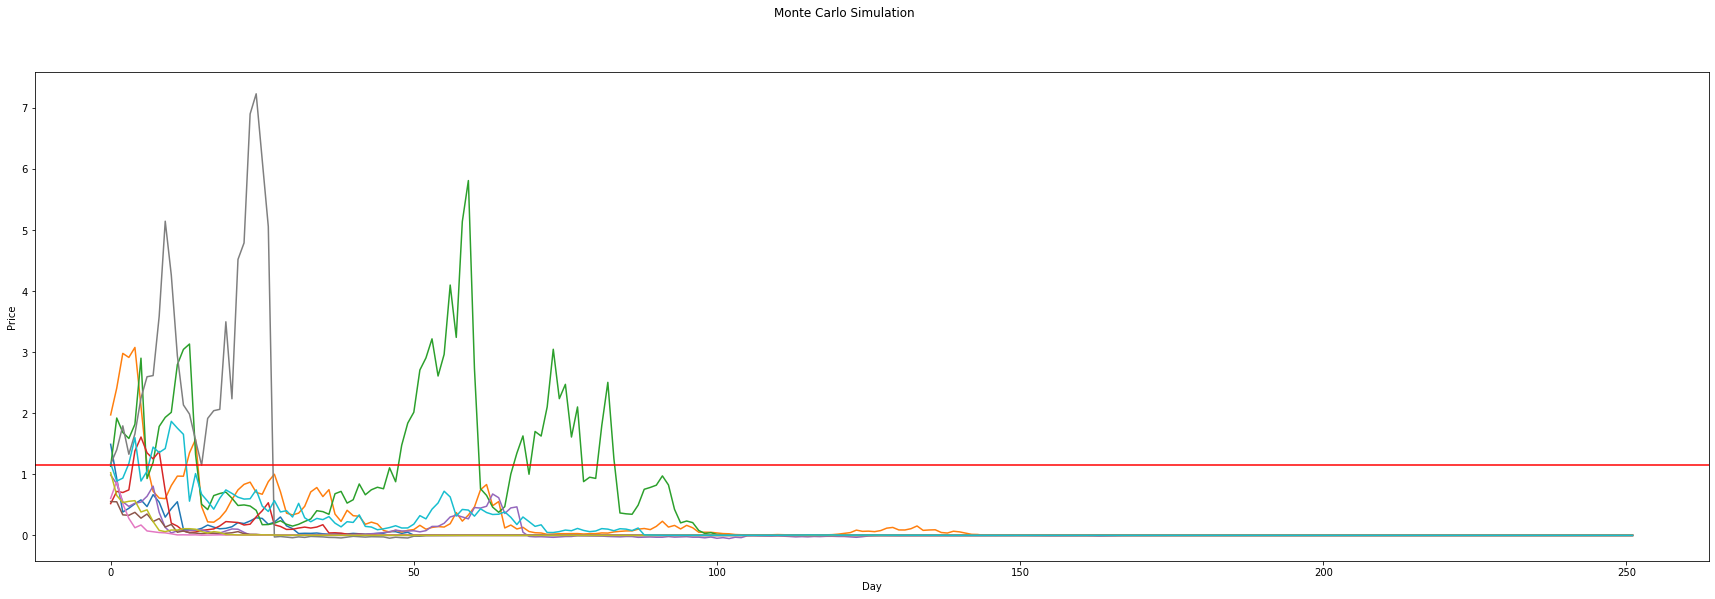

In [69]:
fig = plt.figure(figsize=(30,9))
fig.suptitle('Monte Carlo Simulation')
plt.plot(simulation_df)
plt.axhline(y = last_Close, color = 'r', linestyle = '-')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

## Volatility Prediction Using SVM

### Preparing testing and training dataset

In [70]:
training_set = df.iloc[:, 9:10].values
X_tr = []
y_tr = []
for i in range(10, df.shape[0]):
    X_tr.append(training_set[i-10:i,0])
    y_tr.append(training_set[i,0])
X_tr, y_tr = np.array(X_tr), np.array(y_tr)

#### RBF model

In [46]:
svr_rbf = SVR(kernel='rbf',C=10,gamma=10)

In [47]:
y_rbf = svr_rbf.fit(X_tr,y_tr).predict(X_tr)

In [48]:
predicted_vol_rbf = np.exp(y_rbf)

#### Linear model

In [49]:
svr_linear = SVR(kernel='linear',C=10)

In [50]:
y_linear = svr_linear.fit(X_tr,y_tr).predict(X_tr)

In [51]:
predicted_vol_linear = np.exp(y_linear)

#### Polynomial Model

In [52]:
#svr_poly = SVR(kernel = 'poly',C=10)

In [53]:
#y_poly = svr_poly.fit(X_tr,y_tr).predict(X_tr)

In [54]:
#predicted_vol_poly = np.exp(y_poly)

### Ploting Volatility Observed, predicted Volatility using RBF,predicted Volatility using Linear SVR

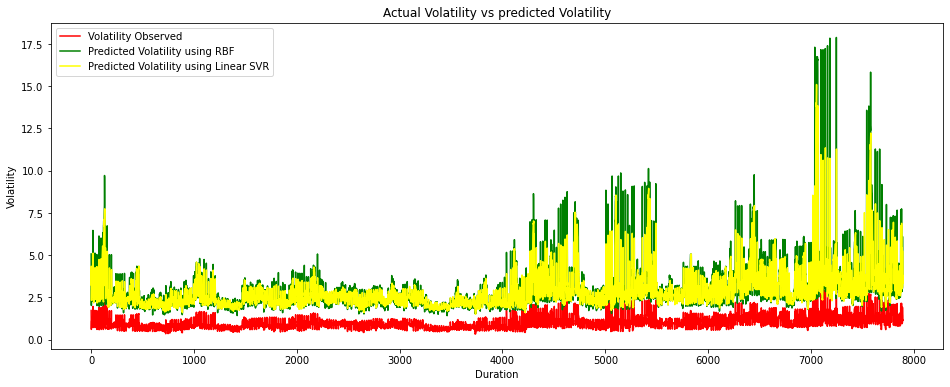

In [71]:
# Visualising the results
plt.figure(figsize=(16,6))
plt.plot(df.iloc[10:, 9:10].values, color = 'red', label = 'Volatility Observed')
plt.plot(predicted_vol_rbf, color = 'green', label = 'Predicted Volatility using RBF')
plt.plot(predicted_vol_linear, color = 'yellow', label = 'Predicted Volatility using Linear SVR')
#plt.plot(predicted_vol, color = 'green', label = 'LSTM Predicted Volatility')
plt.title('Actual Volatility vs predicted Volatility')
plt.xlabel('Duration')
plt.ylabel('Volatility')
plt.legend()
plt.show()

### Calculating RMSE value for SVM Model

In [72]:
print('RMSE calculated for SVM:', np.sqrt(metrics.mean_squared_error(df.iloc[10:, 9:10].values, predicted_vol_linear)))

RMSE calculated for SVM: 2.0727838834598478


## Volatility Prediction using Random Forest

#### Create Random Forest Regressor Model

In [57]:
ran_mod = RandomForestRegressor()

In [58]:
rand_mod = ran_mod.fit(X_tr, y_tr)

### Predicted Volatility

In [59]:
predicted_vol_rand = rand_mod.predict(X_tr)

### Ploting Volatility Observed, predicted Volatility using Random Forest

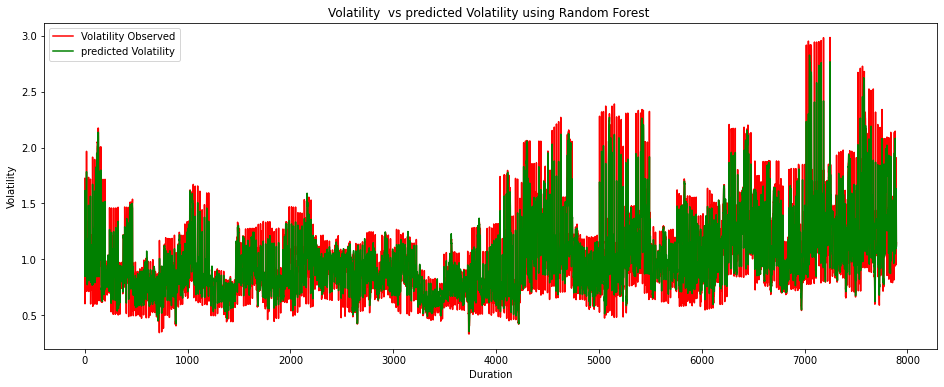

In [73]:
# Visualising the results
plt.figure(figsize=(16,6))
plt.plot(df.iloc[10:, 9:10].values, color = 'red', label = 'Volatility Observed')
plt.plot(predicted_vol_rand, color = 'green', label = 'predicted Volatility')
plt.title('Volatility  vs predicted Volatility using Random Forest ')
plt.xlabel('Duration')
plt.ylabel('Volatility')
plt.legend()
plt.show()

### Calculating RMSE value for Random Forest Model

In [74]:
print('RMSE calculated for Random Forest:', np.sqrt(metrics.mean_squared_error(df.iloc[10:, 9:10].values, predicted_vol_rand)))

RMSE calculated for Random Forest: 0.0891466943157896
